# 06__tf_tissue_sp
# calculating tissue specificity of TFs (across HepG2, HeLa, and K562)

in this notebook, i calculate the tissue specificity of TFs across the 3 cell types in our MPRAs using ENCODE RNA-seq data. then, i correlate motif coverage (# bp covered and maximum coverage) as well as average TF specificity with MPRA activities and specificities.

note: the FIMO mappings and coverage calculations were done separately (see methods)

------

figures in this notebook:
- **Fig 2C**: KDE plot of correlations of MPRA activity & specificity with each of the 3 metrics

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from scipy import signal
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def fix_small_decimal(row):
    if row.max_cov < 1:
        return 0
    else:
        return row.max_cov

In [4]:
def get_cage_id(row):
    if "Enhancer" in row.unique_id:
        return row.unique_id.split("__")[1]
    else:
        return row.unique_id.split("__")[2]

## variables

In [5]:
index_dir = "../../data/00__index"
index_f = "%s/tss_oligo_pool.index.txt" % index_dir

In [6]:
hepg2_activ_f = "../../data/02__activs/POOL1__pMPRA1__HepG2__activities_per_element.txt"
hela_activ_f = "../../data/02__activs/POOL1__pMPRA1__HeLa__activities_per_element.txt"
k562_activ_f = "../../data/02__activs/POOL1__pMPRA1__K562__activities_per_element.txt"

In [7]:
fimo_f = "../../misc/03__fimo/00__fimo_outputs/all_fimo_map.new_deduped.txt.gz"
fimo_chip_f = "../../misc/03__fimo/00__fimo_outputs/all_fimo_map.new_chip_intersected.new_deduped.txt.gz"
pool1_fimo_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.new_deduped.txt"
pool1_fimo_chip_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.new_chip_intersected.new_deduped.txt"
pool1_fimo_no_ets_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.no_ETS_motifs.new_deduped.txt"
pool1_fimo_no_ets_chip_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.txt"

In [8]:
fimo_bp_cov_f = "../../data/04__coverage/all_fimo_map.new_deduped.bp_covered.txt"
fimo_max_cov_f = "../../data/04__coverage/all_fimo_map.new_deduped.max_coverage.txt"

fimo_chip_bp_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.new_deduped.bp_covered.txt"
fimo_chip_max_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.new_deduped.max_coverage.txt"

fimo_clust_bp_cov_f = "../../data/04__coverage/all_fimo_map.bulyk_clusters.new_deduped.bp_covered.txt"
fimo_clust_max_cov_f = "../../data/04__coverage/all_fimo_map.bulyk_clusters.new_deduped.max_coverage.txt"

fimo_mosbat_bp_cov_f = "../../data/04__coverage/all_fimo_map.mosbat_clusters.bp_covered.txt"
fimo_mosbat_max_cov_f = "../../data/04__coverage/all_fimo_map.mosbat_clusters.max_coverage.txt"

In [9]:
fimo_no_ets_bp_cov_f = "../../data/04__coverage/all_fimo_map.no_ETS_motifs.new_deduped.bp_covered.txt"
fimo_no_ets_max_cov_f = "../../data/04__coverage/all_fimo_map.no_ETS_motifs.new_deduped.max_coverage.txt"

fimo_no_ets_chip_bp_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.bp_covered.txt"
fimo_no_ets_chip_max_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.max_coverage.txt"

In [10]:
pool1_fimo_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.new_deduped.bp_covered.txt"
pool1_fimo_max_cov_f = "../../data/04__coverage/pool1_fimo_map.new_deduped.max_coverage.txt"

pool1_fimo_chip_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.new_deduped.bp_covered.txt"
pool1_fimo_chip_max_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.new_deduped.max_coverage.txt"

In [11]:
pool1_fimo_no_ets_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.no_ETS_motifs.new_deduped.bp_covered.txt"
pool1_fimo_no_ets_max_cov_f = "../../data/04__coverage/pool1_fimo_map.no_ETS_motifs.new_deduped.max_coverage.txt"

pool1_fimo_no_ets_chip_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.bp_covered.txt"
pool1_fimo_no_ets_chip_max_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.max_coverage.txt"

In [12]:
tf_ts_f = "../../data/04__coverage/TF_tissue_specificities.from_CAGE.txt"

In [13]:
cage_v_mpra_f = "../../data/02__activs/POOL1__pMPRA1__CAGE_vs_MPRA_activs.txt"

In [14]:
tss_cage_map_f = "../../misc/00__tss_properties/mpra_tss_detailed_info.txt"
enh_cage_map_f = "../../misc/00__tss_properties/enhancer_id_map.txt"

## 1. import data

In [15]:
fimo = pd.read_table(fimo_f, sep="\t", header=None, compression="gzip")
fimo.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", "end", 
                "motif", "motif_score", "motif_strand"]
fimo.head()

,motif_chr,motif_start,motif_end,unique_id,score,strand,chr,start,end,motif,motif_score,motif_strand
0,chr10,100027916,100027925,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,chr10,100027914,100027925,NRF1,12.7455,-
1,chr10,100027946,100027957,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,chr10,100027946,100027957,E2F6,13.5862,-
2,chr10,100027961,100027973,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,chr10,100027961,100027973,TFAP2A(var.2),13.9273,+
3,chr10,100027961,100027973,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,chr10,100027961,100027973,TFAP2B,13.5091,-
4,chr10,100027961,100027973,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,chr10,100027961,100027973,TFAP2C,13.1735,+


In [16]:
fimo_chip = pd.read_table(fimo_chip_f, sep="\t", header=None, compression="gzip")
fimo_chip.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", "end", 
                     "motif", "motif_score", "motif_strand"]

In [17]:
pool1_fimo = pd.read_table(pool1_fimo_f, sep="\t", header=None)
pool1_fimo.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", "end", 
                      "motif", "motif_score", "motif_strand"]

In [18]:
pool1_fimo_chip = pd.read_table(pool1_fimo_chip_f, sep="\t", header=None)
pool1_fimo_chip.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", 
                           "end", "motif", "motif_score", "motif_strand"]

In [19]:
pool1_fimo_no_ets = pd.read_table(pool1_fimo_no_ets_f, sep="\t", header=None)
pool1_fimo_no_ets.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", 
                             "end", "motif", "motif_score", "motif_strand"]

In [20]:
pool1_fimo_no_ets_chip = pd.read_table(pool1_fimo_no_ets_chip_f, sep="\t", header=None)
pool1_fimo_no_ets_chip.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", 
                                  "start", "end", "motif", "motif_score", "motif_strand"]

In [21]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "oligo_type", "unique_id", "dupe_info", "SNP", "seq_name"]]
index_elem = index_elem.drop_duplicates()

In [22]:
hepg2_activ = pd.read_table(hepg2_activ_f, sep="\t")
hela_activ = pd.read_table(hela_activ_f, sep="\t")
k562_activ = pd.read_table(k562_activ_f, sep="\t")

In [23]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

In [24]:
fimo_bp_cov = pd.read_table(fimo_bp_cov_f, sep="\t", header=None)
fimo_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                       "frac_bp_cov"]

fimo_max_cov = pd.read_table(fimo_max_cov_f, sep="\t", header=None)
fimo_max_cov.columns = ["unique_id", "max_cov"]

fimo_cov = fimo_bp_cov.merge(fimo_max_cov, on="unique_id")
print(len(fimo_cov))
fimo_cov.head()

56562


,chr,start,end,unique_id,score,strand,n_motifs,n_bp_cov,seq_len,frac_bp_cov,max_cov
0,chr10,100027916,100028031,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,19,66,115,0.573913,7
1,chr10,100074495,100074610,Enhancer__chr10:100074404-100074582,0,+,26,91,115,0.791304,9
2,chr10,100076068,100076183,Enhancer__chr10:100076038-100076149,0,+,25,78,115,0.678261,8
3,chr10,100076605,100076720,Enhancer__chr10:100076500-100076699,0,+,21,89,115,0.773913,8
4,chr10,100083158,100083273,Enhancer__chr10:100082942-100083374,0,+,36,93,115,0.808696,13


In [25]:
fimo_chip_bp_cov = pd.read_table(fimo_chip_bp_cov_f, sep="\t", header=None)
fimo_chip_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                            "frac_bp_cov"]

fimo_chip_max_cov = pd.read_table(fimo_chip_max_cov_f, sep="\t", header=None)
fimo_chip_max_cov.columns = ["unique_id", "max_cov"]

fimo_chip_cov = fimo_chip_bp_cov.merge(fimo_chip_max_cov, on="unique_id")
print(len(fimo_chip_cov))

40360


In [26]:
fimo_clust_bp_cov = pd.read_table(fimo_clust_bp_cov_f, sep="\t", header=None)
fimo_clust_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                             "frac_bp_cov"]

fimo_clust_max_cov = pd.read_table(fimo_clust_max_cov_f, sep="\t", header=None)
fimo_clust_max_cov.columns = ["unique_id", "max_cov"]

fimo_clust_cov = fimo_clust_bp_cov.merge(fimo_clust_max_cov, on="unique_id")
print(len(fimo_clust_cov))

35093


In [27]:
fimo_mosbat_bp_cov = pd.read_table(fimo_mosbat_bp_cov_f, sep="\t", header=None)
fimo_mosbat_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                             "frac_bp_cov"]

fimo_mosbat_max_cov = pd.read_table(fimo_mosbat_max_cov_f, sep="\t", header=None)
fimo_mosbat_max_cov.columns = ["unique_id", "max_cov"]

fimo_mosbat_cov = fimo_mosbat_bp_cov.merge(fimo_mosbat_max_cov, on="unique_id")
print(len(fimo_mosbat_cov))

56514


In [28]:
pool1_fimo_bp_cov = pd.read_table(pool1_fimo_bp_cov_f, sep="\t", header=None)
pool1_fimo_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                             "frac_bp_cov"]

pool1_fimo_max_cov = pd.read_table(pool1_fimo_max_cov_f, sep="\t", header=None)
pool1_fimo_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_cov = pool1_fimo_bp_cov.merge(pool1_fimo_max_cov, on="unique_id")
print(len(pool1_fimo_cov))

4660


In [29]:
pool1_fimo_chip_bp_cov = pd.read_table(pool1_fimo_chip_bp_cov_f, sep="\t", header=None)
pool1_fimo_chip_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", 
                                  "seq_len", "frac_bp_cov"]

pool1_fimo_chip_max_cov = pd.read_table(pool1_fimo_chip_max_cov_f, sep="\t", header=None)
pool1_fimo_chip_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_chip_cov = pool1_fimo_chip_bp_cov.merge(pool1_fimo_chip_max_cov, on="unique_id")
print(len(pool1_fimo_chip_cov))

4348


In [30]:
pool1_fimo_no_ets_bp_cov = pd.read_table(pool1_fimo_no_ets_bp_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", 
                                    "seq_len", "frac_bp_cov"]

pool1_fimo_no_ets_max_cov = pd.read_table(pool1_fimo_no_ets_max_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_no_ets_cov = pool1_fimo_no_ets_bp_cov.merge(pool1_fimo_no_ets_max_cov, on="unique_id")
print(len(pool1_fimo_no_ets_cov))

4660


In [31]:
pool1_fimo_no_ets_chip_bp_cov = pd.read_table(pool1_fimo_no_ets_chip_bp_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_chip_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", 
                                         "n_bp_cov", "seq_len", "frac_bp_cov"]

pool1_fimo_no_ets_chip_max_cov = pd.read_table(pool1_fimo_no_ets_chip_max_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_chip_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_no_ets_chip_cov = pool1_fimo_no_ets_chip_bp_cov.merge(pool1_fimo_no_ets_chip_max_cov, on="unique_id")
print(len(pool1_fimo_no_ets_chip_cov))

4319


In [32]:
all_cov_dfs = {"fimo": fimo_cov, "fimo_chip": fimo_chip_cov, "fimo_clust": fimo_clust_cov,  
               "pool1_fimo": pool1_fimo_cov, "pool1_fimo_chip": pool1_fimo_chip_cov, 
               "pool1_fimo_no_ets": pool1_fimo_no_ets_cov, 
               "pool1_fimo_no_ets_chip": pool1_fimo_no_ets_chip_cov,
               "fimo_mosbat": fimo_mosbat_cov}

all_motif_dfs = {"fimo": fimo, "fimo_chip": fimo_chip, "pool1_fimo": pool1_fimo, "pool1_fimo_chip": pool1_fimo_chip,
                 "pool1_fimo_no_ets": pool1_fimo_no_ets, "pool1_fimo_no_ets_chip": pool1_fimo_no_ets_chip}

In [33]:
for key in all_cov_dfs.keys():
    df = all_cov_dfs[key]
    df["max_cov"] = df.apply(fix_small_decimal, axis=1)
    df["log_n_motifs"] = np.log(df["n_motifs"]+1)
    df["log_bp_cov"] = np.log(df["n_bp_cov"]+1)
    df["log_max_cov"] = np.log(df["max_cov"]+1)
    df["cage_id"] = df.apply(get_cage_id, axis=1)

fimo_chip_cov.head()

,chr,start,end,unique_id,score,strand,n_motifs,n_bp_cov,seq_len,frac_bp_cov,max_cov,log_n_motifs,log_bp_cov,log_max_cov,cage_id
0,chr10,100027916,100028031,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,3,26,115,0.226087,1,1.386294,3.295837,0.693147,"chr10:100027943..100027958,-"
1,chr10,100074495,100074610,Enhancer__chr10:100074404-100074582,0,+,5,25,115,0.217391,2,1.791759,3.258097,1.098612,chr10:100074404-100074582
2,chr10,100076068,100076183,Enhancer__chr10:100076038-100076149,0,+,2,22,115,0.191304,1,1.098612,3.135494,0.693147,chr10:100076038-100076149
3,chr10,100076605,100076720,Enhancer__chr10:100076500-100076699,0,+,6,53,115,0.460870,3,1.945910,3.988984,1.386294,chr10:100076500-100076699
4,chr10,100083158,100083273,Enhancer__chr10:100082942-100083374,0,+,10,74,115,0.643478,2,2.397895,4.317488,1.098612,chr10:100082942-100083374


In [34]:
for key in all_motif_dfs.keys():
    df = all_motif_dfs[key]
    df["cage_id"] = df.apply(get_cage_id, axis=1)
    
fimo.sample(5)

,motif_chr,motif_start,motif_end,unique_id,score,strand,chr,start,end,motif,motif_score,motif_strand,cage_id
509086,chr19,11925034,11925048,protein_coding__p1@ZNF440__chr19:11925071..119...,0,+,chr19,11925034,11925048,KLF14,9.36207,-,"chr19:11925071..11925113,+::"
657221,chr2,18741931,18741947,protein_coding__p1@RDH14__chr2:18741882..18741...,0,-,chr2,18741931,18741947,GLIS1,-8.36538,-,"chr2:18741882..18741968,-::"
1065780,chr8,22526621,22526631,protein_coding__p1@BIN3__chr8:22526597..225266...,0,-,chr8,22526621,22526631,ETV1,13.34550,-,"chr8:22526597..22526657,-::"
1128880,chr9,841631,841641,"protein_coding__p1@DMRT1__chr9:841691..841702,+::",0,+,chr9,841631,841641,Tcfl5,10.75000,-,"chr9:841691..841702,+::"
951673,chr6,2842209,2842226,protein_coding__p2@SERPINB1__chr6:2842219..284...,0,-,chr6,2842209,2842226,Rarg(var.2),-5.47273,+,"chr6:2842219..2842246,-::"


In [35]:
tf_ts = pd.read_table(tf_ts_f, sep="\t")
tf_ts.head()

,tf,tissue_sp_all,tissue_sp_3,K562_exp,HeLa_exp,HepG2_exp
0,PAX7,0.990032,NaN,0.000000,0.000000,0.000000
1,HNF1B,0.979589,0.666667,0.000000,0.000000,5.889702
2,LIN54,0.794230,0.412303,17.857032,18.290625,47.369957
3,IRF3,0.719361,0.089475,23.938784,29.128210,26.498907
4,MEF2C,0.978378,0.665278,112.089652,0.335948,0.131145


In [36]:
cage_v_mpra = pd.read_table(cage_v_mpra_f, sep="\t")
cage_v_mpra["oligo_reg"] = cage_v_mpra["unique_id"].str.split("__", expand=True)[2]
cage_v_mpra.head()

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,0.786378,0.665068,1.400056,0.142230,"chr10:11936664..11936778,-"
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,div_lnc,0.377764,0.151243,-0.054568,0.214384,"chr10:28821597..28821711,-"
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,1.258762,0.158191,1.378850,0.118103,"chr10:29698406..29698520,+"
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,0.938897,0.140302,0.130581,0.269957,"chr10:97667625..97667739,-"
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,div_lnc,0.465003,0.292028,3.046316,0.085757,"chr11:27528316..27528430,+"


In [37]:
tss_cage_map = pd.read_table(tss_cage_map_f, sep="\t")
tss_cage_map.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


In [38]:
enh_cage_map = pd.read_table(enh_cage_map_f, sep="\t")
enh_cage_map.head()

,enhancer_id,TSS_id_Neg,TSS_id_Pos,distTSSs,sum_1828_samples,avExpALL,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,avExpCS,oligo_reg_Neg,oligo_reg_Pos
0,chr1:1004646-1004986,"chr1:1004724..1004725,-","chr1:1004806..1004807,+",239,2186.660,1.196204,1.75865,1.718966,0.0,0.278501,0.634142,0.471889,0.224833,0.0,0.193772,0.586750,"chr1:1004690..1004804,-","chr1:1004727..1004841,+"
1,chr1:108483614-108484145,"chr1:108483919..108483920,-","chr1:108484014..108484015,+",706,949.696,0.519527,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108483885..108483999,-","chr1:108483935..108484049,+"
2,chr1:108592862-108593109,"chr1:108592862..108592863,-","chr1:108592945..108592946,+",84,1794.280,0.981554,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108592828..108592942,-","chr1:108592866..108592980,+"
3,chr1:109099158-109099479,"chr1:109099171..109099172,-","chr1:109099303..109099304,+",159,1366.590,0.747588,0.00000,0.000000,0.0,0.000000,0.000000,0.078648,0.000000,0.0,0.000000,0.008739,"chr1:109099137..109099251,-","chr1:109099224..109099338,+"
4,chr1:109788948-109789150,"chr1:109788975..109788976,-","chr1:109789149..109789150,+",229,2093.390,1.145181,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:109788941..109789055,-","chr1:109789070..109789184,+"


## 2. for pool1: join coverage and motif files with MPRA expr/spec files

In [39]:
# since enhancers have 2 TSS_ids, need to join these separately
tmp = cage_v_mpra.merge(tss_cage_map[["oligo_reg", "TSS_id"]], on="oligo_reg", how="left")
tmp_enh_pos = tmp[(tmp["unique_id"].str.contains("Enhancer")) & (tmp["TSS_id"].str[-1] == "+")]
tmp_enh_neg = tmp[(tmp["unique_id"].str.contains("Enhancer")) & (tmp["TSS_id"].str[-1] == "-")]

tmp_enh_pos = tmp_enh_pos.merge(enh_cage_map[["TSS_id_Pos", "enhancer_id"]], left_on="TSS_id", right_on="TSS_id_Pos",
                                how="left")
tmp_enh_neg = tmp_enh_neg.merge(enh_cage_map[["TSS_id_Neg", "enhancer_id"]], left_on="TSS_id", right_on="TSS_id_Neg",
                                how="left")
tmp_enh_pos = tmp_enh_pos.drop("TSS_id_Pos", axis=1)
tmp_enh_neg = tmp_enh_neg.drop("TSS_id_Neg", axis=1)
tmp_enh = tmp_enh_pos.append(tmp_enh_neg)
tmp_enh["TSS_id"] = tmp_enh["enhancer_id"]
tmp_enh.drop("enhancer_id", axis=1, inplace=True)
tmp_enh.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
273,WILDTYPE__Enhancer.noflip.NA__chr8:62679813..6...,Enhancer,0.055995,0.406557,-1.961143,0.236891,"chr8:62679813..62679927,-",chr8:62679636-62680132
247,WILDTYPE__Enhancer.noflip.NA__chr5:100113448.....,Enhancer,0.015315,0.666667,-0.031772,0.230417,"chr5:100113448..100113562,-",chr5:100113377-100113868
0,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,Enhancer,0.000000,NaN,-1.659291,0.221290,"chr10:30782546..30782660,+",chr10:30782405-30782910
235,WILDTYPE__Enhancer.noflip.NA__chr2:208176289.....,Enhancer,0.007682,0.666667,2.380135,0.153395,"chr2:208176289..208176403,+",chr2:208176046-208176541
87,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr5...,Enhancer,0.000000,NaN,-2.039454,0.445833,"chr5:40410488..40410602,-",chr5:40410103-40410947


In [40]:
tmp_no_enh = tmp[~tmp["unique_id"].str.contains("Enhancer")]
cage_v_mpra = tmp_no_enh.append(tmp_enh)
cage_v_mpra.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
1025,WILDTYPE__Antisense.noflip.NA__chr11:70244440....,div_lnc,0.716815,0.044094,-1.177274,0.093583,"chr11:70244440..70244554,-","chr11:70244451..70244505,-"
1995,WILDTYPE__mrna.noflip.NA__chr2:136499246..1364...,protein_coding,1.320543,0.051119,-1.488498,0.302343,"chr2:136499246..136499360,+","chr2:136499305..136499381,+"
1640,WILDTYPE__Lincrna.noflip.NA__chr22:27053472..2...,intergenic,0.009165,0.666667,0.422933,0.183777,"chr22:27053472..27053586,+","chr22:27053545..27053561,+"
14,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,Enhancer,0.252262,0.026592,-1.772559,0.021159,"chr22:41047707..41047821,-",chr22:41047729-41047883
653,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr13:10...,protein_coding,0.000000,NaN,-2.008370,0.485906,"chr13:102104846..102104960,+","chr13:102104920..102104936,+"


In [42]:
cage_v_mpra.PromType2.value_counts()

protein_coding    599
Enhancer          564
intergenic        425
div_lnc           353
div_pc            137
Name: PromType2, dtype: int64

In [43]:
pool1_fimo_cov = pool1_fimo_cov.merge(cage_v_mpra, on="unique_id")
pool1_fimo = pool1_fimo.merge(cage_v_mpra, on="unique_id")
pool1_fimo_cov["cage_id"] = pool1_fimo_cov["TSS_id"]
pool1_fimo["cage_id"] = pool1_fimo["TSS_id"]
all_cov_dfs["pool1_fimo"] = pool1_fimo_cov
all_motif_dfs["pool1_fimo"] = pool1_fimo
print(len(pool1_fimo_cov))
pool1_fimo_cov.sample(5)

2076


,chr,start,end,unique_id,score,strand,n_motifs,n_bp_cov,seq_len,frac_bp_cov,...,log_bp_cov,log_max_cov,cage_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
249,chr11,62622801,62622915,WILDTYPE__Lincrna.noflip.NA__chr11:62622801..6...,1,-,4,42,114,0.368421,...,3.761200,1.098612,"chr11:62622833..62622839,-",div_lnc,0.143108,0.247555,-1.017493,0.281407,"chr11:62622801..62622915,-","chr11:62622833..62622839,-"
705,chr1,59250755,59250869,WILDTYPE__Lincrna.noflip.NA__chr1:59250755..59...,1,+,37,73,114,0.640351,...,4.304065,3.091042,"chr1:59250815..59250848,+",intergenic,0.091471,0.530494,0.093626,0.075114,"chr1:59250755..59250869,+","chr1:59250815..59250848,+"
1522,chr5,173763185,173763299,WILDTYPE__Lincrna.noflip.NA__chr5:173763185..1...,1,+,7,40,114,0.350877,...,3.713572,1.791759,"chr5:173763250..173763302,+",intergenic,0.096098,0.666667,-1.952821,0.483426,"chr5:173763185..173763299,+","chr5:173763250..173763302,+"
281,chr1,167587039,167587153,WILDTYPE__Enhancer.noflip.NA__chr1:167587039.....,1,-,57,77,114,0.675439,...,4.356709,2.890372,chr1:167586596-167587245,Enhancer,0.241065,0.666667,-0.363099,0.076945,"chr1:167587039..167587153,-",chr1:167586596-167587245
1769,chr7,23720421,23720535,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,1,-,14,57,114,0.500000,...,4.060443,1.791759,"chr7:23720431..23720470,-",div_lnc,0.000000,NaN,-2.121316,0.328832,"chr7:23720421..23720535,-","chr7:23720431..23720470,-"


In [44]:
pool1_fimo_chip_cov = pool1_fimo_chip_cov.merge(cage_v_mpra, on="unique_id")

# for old chip files:
#pool1_fimo_chip = pool1_fimo_chip.drop("unique_id", axis=1).merge(cage_v_mpra, left_on="cage_id", right_on="TSS_id")

# for new chip files:
pool1_fimo_chip = pool1_fimo_chip.merge(cage_v_mpra, on="unique_id")

pool1_fimo_chip_cov["cage_id"] = pool1_fimo_chip_cov["TSS_id"]
pool1_fimo_chip["cage_id"] = pool1_fimo_chip["TSS_id"]
all_cov_dfs["pool1_fimo_chip"] = pool1_fimo_chip_cov
all_motif_dfs["pool1_fimo_chip"] = pool1_fimo_chip
print(len(pool1_fimo_chip_cov))

1926


In [45]:
pool1_fimo_no_ets_cov = pool1_fimo_no_ets_cov.merge(cage_v_mpra, on="unique_id")
pool1_fimo_no_ets = pool1_fimo_no_ets.merge(cage_v_mpra, on="unique_id")
pool1_fimo_no_ets_cov["cage_id"] = pool1_fimo_no_ets_cov["TSS_id"]
pool1_fimo_no_ets["cage_id"] = pool1_fimo_no_ets["TSS_id"]
all_cov_dfs["pool1_fimo_no_ets"] = pool1_fimo_no_ets_cov
all_motif_dfs["pool1_fimo_no_ets"] = pool1_fimo_no_ets
print(len(pool1_fimo_no_ets_cov))

2076


In [46]:
pool1_fimo_no_ets_chip_cov = pool1_fimo_no_ets_chip_cov.merge(cage_v_mpra, on="unique_id")

# for old chip files:
# pool1_fimo_no_ets_chip = pool1_fimo_no_ets_chip.drop("unique_id", axis=1).merge(cage_v_mpra, left_on="cage_id", 
#                                                                                 right_on="TSS_id")

# for new chip files:
pool1_fimo_no_ets_chip = pool1_fimo_no_ets_chip.merge(cage_v_mpra, on="unique_id")

pool1_fimo_no_ets_chip_cov["cage_id"] = pool1_fimo_no_ets_chip_cov["TSS_id"]
pool1_fimo_no_ets_chip["cage_id"] = pool1_fimo_no_ets_chip["TSS_id"]
all_cov_dfs["pool1_fimo_no_ets_chip"] = pool1_fimo_no_ets_chip_cov
all_motif_dfs["pool1_fimo_no_ets_chip"] = pool1_fimo_no_ets_chip
print(len(pool1_fimo_no_ets_chip_cov))

1912


In [47]:
pool1_fimo_no_ets_chip.head()

,motif_chr,motif_start,motif_end,unique_id,score,strand,chr,start,end,motif,motif_score,motif_strand,cage_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
0,chr1,713979,713991,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,713979,713991,E2F1,11.96720,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
1,chr1,713979,713991,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,713979,713991,E2F1,11.55740,+,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
2,chr1,714030,714041,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,714030,714041,SP1,10.48080,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
3,chr1,714030,714045,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,714030,714045,SP2,10.44830,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
4,chr1,714052,714069,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,714052,714069,SP4,7.27273,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"


## 3. find avg TF/motif specificity per tile

In [48]:
all_spec_dfs = {}
for key in all_motif_dfs.keys():
    print(key)
    df = all_motif_dfs[key]
    df["motif"] = df["motif"].str.upper()
    df = df.merge(tf_ts, left_on="motif", right_on="tf", how="left")
    df_nonan = df[~pd.isnull(df["tissue_sp_3"])]
    df_deduped = df_nonan.drop_duplicates(subset=["motif", "unique_id"])
    avg_sp = df_deduped.groupby(["cage_id"])["tissue_sp_3"].agg("mean").reset_index()
    avg_sp.columns = ["cage_id", "avg_tf_tissue_sp"]
    avg_sp["log_avg_tf_tissue_sp"] = np.log(avg_sp["avg_tf_tissue_sp"]+1)
    all_spec_dfs[key] = avg_sp
avg_sp.sample(5)

fimo
fimo_chip
pool1_fimo
pool1_fimo_chip
pool1_fimo_no_ets
pool1_fimo_no_ets_chip


,cage_id,avg_tf_tissue_sp,log_avg_tf_tissue_sp
840,chr22:29261004-29261197,0.497076,0.403514
757,"chr20:25731814..25731865,+",0.487283,0.396951
736,"chr1:93811339..93811410,-",0.451685,0.372725
152,chr11:65244638-65245303,0.357927,0.305959
1222,"chr5:33049491..33049516,-",0.485069,0.395461


## 4. merge and write coverage files

In [49]:
file_prefixes = {"fimo": "all_fimo_map", "fimo_chip": "all_fimo_map.chip_intersected", 
                 "fimo_clust": "all_fimo_map.bulyk_clusters", 
                 "pool1_fimo": "pool1_fimo_map", "pool1_fimo_chip": "pool1_fimo_map.chip_intersected", 
                 "pool1_fimo_no_ets": "pool1_fimo_map.no_ETS_motifs", 
                 "pool1_fimo_no_ets_chip": "pool1_fimo_map.chip_intersected.no_ETS_motifs",
                 "fimo_mosbat": "all_fimo_map.mosbat_clusters"}

for key in all_cov_dfs.keys():
    print(key)
    name = file_prefixes[key]
    cov_df = all_cov_dfs[key]
    if key in all_spec_dfs.keys():
        spec_df = all_spec_dfs[key]
        merge_df = cov_df.merge(spec_df, on="cage_id", how="left")
        merge_df = merge_df[["unique_id", "cage_id", "n_motifs", "n_bp_cov", "max_cov", "avg_tf_tissue_sp", 
                             "log_n_motifs", "log_bp_cov", "log_max_cov", "log_avg_tf_tissue_sp"]].drop_duplicates()
    else:
        merge_df = cov_df[["unique_id", "cage_id", "n_motifs", "n_bp_cov", "max_cov", 
                                 "log_n_motifs", "log_bp_cov", "log_max_cov"]].drop_duplicates()
    
    merge_df.to_csv("../../data/04__coverage/%s.all_cov.new.txt" % name, sep="\t", index=False)
    
    if "pool1" in name:
        merge_df = merge_df.merge(cage_v_mpra[["unique_id", "mpra_activ", "mpra_ts"]], on="unique_id")
    all_cov_dfs[key] = merge_df

fimo
fimo_chip
fimo_clust
pool1_fimo
pool1_fimo_chip
pool1_fimo_no_ets
pool1_fimo_no_ets_chip
fimo_mosbat


## 5. plot correlations w/ MPRA data

## tissue specificity

#### fimo only

In [50]:
df = all_cov_dfs["pool1_fimo"]
df.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,mpra_activ,mpra_ts
0,WILDTYPE__mrna.noflip.NA__chr10:102046079..102...,"chr10:102046098..102046122,-",13,39,11,0.417349,2.639057,3.688879,2.484907,0.348788,0.755234,0.339882
1,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr10...,"chr10:102133377..102133394,+",18,61,5,0.444224,2.944439,4.127134,1.791759,0.367572,-1.257574,0.401928
2,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr10:1...,"chr10:1034365..1034411,+",31,77,11,0.391036,3.465736,4.356709,2.484907,0.330049,0.480824,0.144071
3,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr10:10...,"chr10:104597163..104597180,-",10,78,3,0.452162,2.397895,4.369448,1.386294,0.373054,-1.168195,0.270406
4,WILDTYPE__Lincrna.noflip.NA__chr10:106113294.....,"chr10:106113320..106113338,-",25,65,13,0.408014,3.258097,4.189655,2.639057,0.342180,0.412117,0.107425


In [51]:
#cmap = sns.light_palette("#8da0cb", as_cmap=True)
cmap = sns.light_palette("darkslategray", as_cmap=True)

In [52]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_activ"])]
len(no_nan)

2047

r: -0.194622411683, spearman p: 6.38254121464e-19


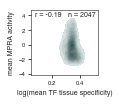

In [53]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

In [54]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_ts"])]
len(no_nan)

1956

r: 0.174477337355, spearman p: 7.76830099959e-15


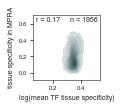

In [55]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

#### fimo intersected w/ chip

In [56]:
df = all_cov_dfs["pool1_fimo_chip"]

In [57]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_activ"])]
len(no_nan)

1887

r: -0.0926340154874, spearman p: 5.57799593204e-05


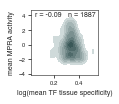

In [58]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
fig.savefig("Fig_2C_3.pdf", bbox_inches="tight", dpi="figure")

In [59]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_ts"])]
len(no_nan)

1798

r: 0.119866943369, spearman p: 3.44074606519e-07


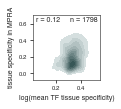

In [60]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
fig.savefig("Fig_2C_6.pdf", bbox_inches="tight", dpi="figure")

## number of bp covered

#### fimo only

In [61]:
df = all_cov_dfs["pool1_fimo"]

In [62]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

2050

r: 0.285490951836, spearman p: 9.52518428583e-40


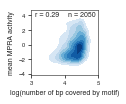

In [63]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")
ax.set_xlim((3,5))

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

In [64]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1959

r: -0.165931840763, spearman p: 1.45899177146e-13


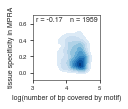

In [65]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")
ax.set_xlim((3, 5))

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

#### fimo intersected w/ chip

In [66]:
df = all_cov_dfs["pool1_fimo_chip"]

In [67]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1899

r: 0.466227983786, spearman p: 4.29077318116e-103


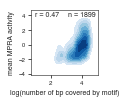

In [68]:
fig = plt.figure(figsize=(1.2, 1.2))
no_0 = no_nan[no_nan["n_bp_cov"] > 0]
all_0 = no_nan[no_nan["n_bp_cov"] == 0]
ax = sns.kdeplot(no_0["log_bp_cov"], no_0["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_1.pdf", bbox_inches="tight", dpi="figure")

In [69]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1810

r: -0.310352568139, spearman p: 1.03997426937e-41


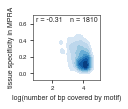

In [70]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_4.pdf", bbox_inches="tight", dpi="figure")

## max overlapping coverage

#### fimo only

In [71]:
df = all_cov_dfs["pool1_fimo"]

In [72]:
cmap = sns.light_palette("firebrick", as_cmap=True)

In [73]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

2050

r: 0.363203310073, spearman p: 5.91007117938e-65


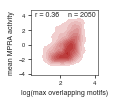

In [74]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

In [75]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1959

r: -0.280937064449, spearman p: 7.36699080159e-37


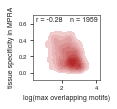

In [76]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

#### fimo intersected w/ chip

In [77]:
df = all_cov_dfs["pool1_fimo_chip"]

In [78]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1899

r: 0.444130555558, spearman p: 1.2818580762e-92


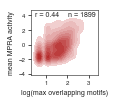

In [79]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_2.pdf", bbox_inches="tight", dpi="figure")

In [80]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1810

r: -0.340141195812, spearman p: 2.93513951774e-50


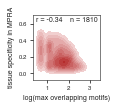

In [81]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_5.pdf", bbox_inches="tight", dpi="figure")